In [1]:
from keras.applications.mobilenet import MobileNet, preprocess_input


image_shape = (128, 128, 3)

features_extractor = MobileNet(include_top=False, input_shape=image_shape)

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, GRU
from keras.layers.wrappers import TimeDistributed


def get_model(extractor, nb_classes=12, nb_frames=12, image_shape=(128, 128, 3), summary=False):
    model = Sequential()
    
    model.add(TimeDistributed(extractor, input_shape=(nb_frames, *image_shape)))
    model.add(TimeDistributed(Flatten()))
    
    model.add(GRU(256, activation=None, return_sequences=False))
    model.add(Activation('tanh'))
    
    model.add(Dense(512))
    model.add(Activation('relu'))
    
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    # congela as ultimas 18 layers da MobileNet
    for layer in model.layers[0].layer.layers[:-6]: # => 6
        layer.trainable = False
    
    if summary:
        print(model.summary())
        
    return model


model = get_model(features_extractor, image_shape=image_shape, summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 12, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 12, 16384)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               12780288  
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                6156      
__________

In [3]:
from keras.optimizers import SGD


model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=0.001), # lr=0.01, nesterov=True
              metrics=['acc'])

In [29]:
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.preprocessing.image import (
    flip_axis, transform_matrix_offset_center, apply_transform
)


# assume que as imagens sempre serao `last_channel`
    
def rotation_matrix(X, rg):
    theta = np.deg2rad(np.random.uniform(-rg, rg))
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

def shift_matrix(X, wrg, hrg, row_axis=1, col_axis=2):
    dx = np.random.uniform(-hrg, hrg)
    dy = np.random.uniform(-wrg, wrg)
    h, w = X[0].shape[row_axis], X[0].shape[col_axis]
    tx = dx * h
    ty = dy * w
    return np.array([[1, 0, tx],
                     [0, 1, ty],
                     [0, 0, 1]])

def shear_matrix(X, intensity):
    shear = np.deg2rad(np.random.uniform(-intensity, intensity))
    return np.array([[1, -np.sin(shear), 0],
                     [0, np.cos(shear), 0],
                     [0, 0, 1]])

def zoom_matrix(X, zoom_range):
    zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)  
    return np.array([[zx, 0, 0],
                     [0, zy, 0],
                     [0, 0, 1]])

def random_seq_transform(X, rtrg=0, wrg=0, hrg=0, shrg=0, zrg=0, row_axis=1, col_axis=2, channel_axis=2,
                    fill_mode='nearest', cval=0.):
    transform_matrix = None
    
    if rtrg != 0:
        transform_matrix = rotation_matrix(X, rtrg)
    if wrg != 0 or hrg != 0:
        shift = shift_matrix(X, wrg, hrg, row_axis=row_axis, col_axis=col_axis)
        transform_matrix = shift if transform_matrix is None else np.dot(transform_matrix, shift)
    if shrg != 0:
        shear = shear_matrix(X, shrg)
        transform_matrix = shear if transform_matrix is None else np.dot(transform_matrix, shear)
    if zrg != 0:
        zoom = zoom_matrix(X, zrg)
        transform_matrix = zoom if transform_matrix is None else np.dot(transform_matrix, zoom)
    
    if not transform_matrix is None:
        h, w = X[0].shape[row_axis], X[0].shape[col_axis]
        transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)        
        
        Xr = []
        
        for x in X:
            Xr.append(apply_transform(x, transform_matrix, channel_axis, fill_mode, cval))
        
        return np.array(Xr)
    else:
        return X

def flip(img):
    """reflete a imagem em relacao ao eixo y."""
    return flip_axis(img, axis=1)

def interval_mapping(image, from_min, from_max, to_min, to_max):
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

def read_video(video_path, size=(128, 128, 3)):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    frames = []
    
    while ret:
        if frame.shape != size:
            frame = cv2.resize(frame, (size[1], size[0]))
        frames.append(frame)
        ret, frame = cap.read()
        
    return frames

In [54]:
import os
import threading
from functools import reduce


def preprocess(video_path, 
               nb_frames=12, 
               size=(128, 128, 3), 
               start_offset_rg=5, 
               rtrg=10, 
               wrg=0.12, 
               hrg=0.10, 
               shrg=20, 
               zrg=0.15,
               toflip=True):
    video = []
    
    if toflip and random.randint(0, 1) == 0:
        toflip = False
        
    for frame in read_video(video_path, size=size):
        frame = preprocess_input(frame.astype(np.float64))
#         if toflip:
#             flip(frame)
        video.append(frame)
        
    start_offset = random.randint(0, start_offset_rg)
    video = [frame for frame in video[start_offset::(len(video)-start_offset)//nb_frames]]
    
    while len(video) < nb_frames:
        video.append(np.zeros(size))
        
    return random_seq_transform(np.array(video[:nb_frames]), 
                            rtrg,
                            wrg, 
                            hrg,
                            shrg,
                            (1.0-zrg, 1.0+zrg))
    
def generator(features, labels, batch_size, nb_frames=12, size=(128, 128, 3)):
    batch_features = np.zeros((batch_size, nb_frames, *size))
    batch_labels = np.zeros((batch_size, len(labels)))
    
    random.shuffle(features)
    lock = threading.Lock()
    index = 0
    
    # not thread-safe
    def pick(features):
        nonlocal index
        with lock:
            if index == len(features):
                random.shuffle(features)
                index = 0
            feature = features[index]
            index += 1
        return feature

    while True:
        for i in range(batch_size):
            feature, label = pick(features)
            batch_features[i] = preprocess(feature, size=size)
            batch_labels[i] = labels[label]

        yield batch_features, batch_labels

def load(dataset_path):
    videos_path = []

    for root, subdir, filesname in os.walk(dataset_path):
        for filename in filesname:
            if '.mp4' in filename:
                videos_path.append(os.path.join(root, filename))

    _class = ['agosto', 'avisar', 'avisar-me', 'branco', 'educado', 'entender', 
              'entender-não', 'esquecer', 'pessoa', 'quente', 'rápido', 'sentimento']

    features = []
    labels = to_categorical(range(len(_class)))

    for i, c in enumerate(_class):
        for path in videos_path:
            if c + '/' in path:
                features.append((path, i))
    
    return features, labels


dataset_path = 'dataset/training'
validation_path = 'dataset/validation'
batch_size = 1

features, labels = load(dataset_path)
vfeatures, vlabels = load(validation_path)

gen = generator(features, labels, batch_size, size=image_shape)
vgen = generator(vfeatures, vlabels, batch_size, size=image_shape)

In [59]:
%%time

# debugar se esta gerando corretamenta as imagens
batch, label = next(gen)

CPU times: user 243 ms, sys: 2.9 ms, total: 246 ms
Wall time: 138 ms


(1, 12, 128, 128, 3) (1, 12)


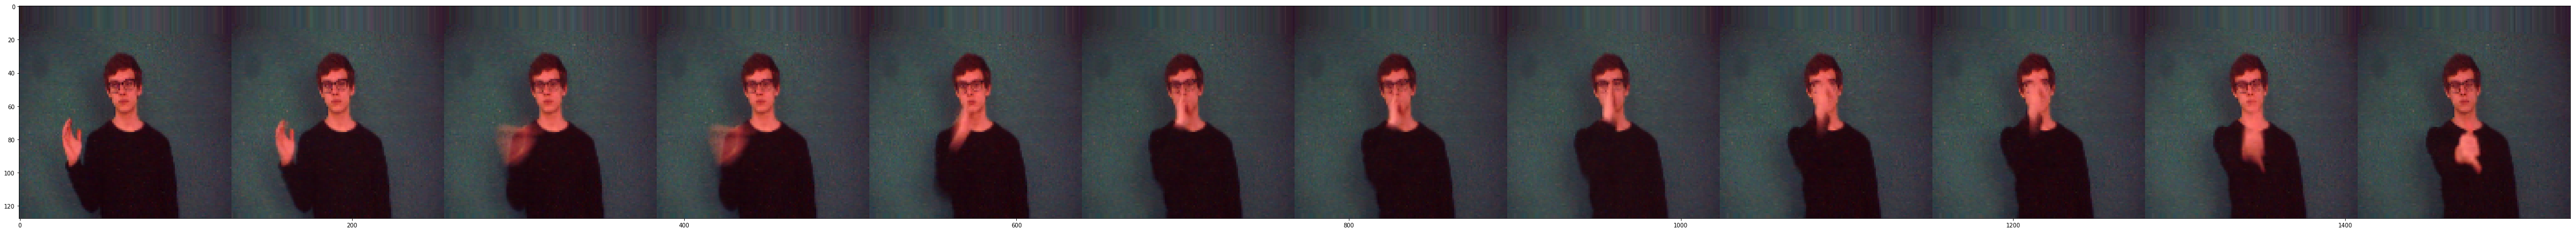

CPU times: user 1.65 s, sys: 275 ms, total: 1.93 s
Wall time: 1.6 s


In [60]:
%%time
print(batch.shape, label.shape)

img = np.concatenate([interval_mapping(img, np.min(img), np.max(img), 0, 255).astype(np.uint8)
                for img in batch[0]], axis=1)

plt.figure(figsize=(80,40))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# first test
history = model.fit_generator(gen, 
                              steps_per_epoch=len(features)/batch_size,
                              validation_data=vgen,
                              validation_steps=len(vfeatures)/batch_size,
                              epochs=10,
                              max_queue_size=30,
                              workers=3,
                              use_multiprocessing=True) # test-only

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
1221/6451 [====>.........................] - ETA: 13:09 - loss: 2.1770 - acc: 0.2858

In [ ]:
model.save_weights('weights.hdf5')

In [ ]:
# testa na mao algumas previsoes
_class = np.array(['agosto', 'avisar', 'avisar-me', 'branco', 'educado', 'entender', 
          'entender-não', 'esquecer', 'pessoa', 'quente', 'rápido', 'sentimento'])

batch, label = next(gen)
predict = model.predict(batch)

print('predict', _class[np.argmax(predict, axis=1)])
print('labels ', _class[np.argmax(label, axis=1)])

In [ ]:
# visualiza um video
img = np.concatenate([interval_mapping(img, np.min(img), np.max(img), 0, 255).astype(np.uint8)
                for img in batch[0]], axis=1)

plt.figure(figsize=(80,40))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Log

### LSTM(256) -> Dense(512) -> Dense(12)

#### Um voluntario, uma camera, >90%

#### SGD(0.001), Doze voluntarios, cam8, 97.63%, 8 frames
```
Epoch 1/10
717/717 [==============================] - 80s 112ms/step - loss: 2.3100 - acc: 0.2092
Epoch 2/10
717/717 [==============================] - 63s 88ms/step - loss: 1.7178 - acc: 0.4533
Epoch 3/10
717/717 [==============================] - 63s 87ms/step - loss: 1.2424 - acc: 0.6318
Epoch 4/10
717/717 [==============================] - 63s 87ms/step - loss: 0.9182 - acc: 0.7378
Epoch 5/10
717/717 [==============================] - 62s 87ms/step - loss: 0.6590 - acc: 0.8243
Epoch 6/10
717/717 [==============================] - 62s 87ms/step - loss: 0.4894 - acc: 0.8926
Epoch 7/10
717/717 [==============================] - 62s 87ms/step - loss: 0.3579 - acc: 0.9331
Epoch 8/10
717/717 [==============================] - 62s 87ms/step - loss: 0.2697 - acc: 0.9540
Epoch 9/10
717/717 [==============================] - 62s 86ms/step - loss: 0.2101 - acc: 0.9609
Epoch 10/10
717/717 [==============================] - 62s 87ms/step - loss: 0.1690 - acc: 0.9763
```

#### SGD, Doze voluntarios, cam[3,8], training[99.93%], validation[45,83%], 8 frames => overfitting

Provavelmente estava refinando dos treinos anteriores

```
Epoch 1/10
1435/1435 [==============================] - 135s 94ms/step - loss: 0.7159 - acc: 0.7624
Epoch 2/10
1435/1435 [==============================] - 124s 86ms/step - loss: 0.4075 - acc: 0.8850
Epoch 3/10
1435/1435 [==============================] - 127s 89ms/step - loss: 0.2650 - acc: 0.9345
Epoch 4/10
1435/1435 [==============================] - 125s 87ms/step - loss: 0.1867 - acc: 0.9547
Epoch 5/10
1435/1435 [==============================] - 133s 93ms/step - loss: 0.1240 - acc: 0.9770
Epoch 6/10
1435/1435 [==============================] - 127s 88ms/step - loss: 0.0961 - acc: 0.9868
Epoch 7/10
1435/1435 [==============================] - 127s 89ms/step - loss: 0.0815 - acc: 0.9895
Epoch 8/10
1435/1435 [==============================] - 125s 87ms/step - loss: 0.0640 - acc: 0.9958
Epoch 9/10
1435/1435 [==============================] - 127s 89ms/step - loss: 0.0590 - acc: 0.9951
Epoch 10/10
1435/1435 [==============================] - 125s 87ms/step - loss: 0.0344 - acc: 0.9993
```

#### SGD, Doze voluntarios, cam[all], training[99.58%], validation[38.70%], 8 frames

```
Epoch 1/10
6451/6451 [==============================] - 623s 97ms/step - loss: 0.8525 - acc: 0.6800
Epoch 2/10
6451/6451 [==============================] - 573s 89ms/step - loss: 0.3967 - acc: 0.8613
Epoch 3/10
6451/6451 [==============================] - 589s 91ms/step - loss: 0.2715 - acc: 0.9054
Epoch 4/10
6451/6451 [==============================] - 563s 87ms/step - loss: 0.1727 - acc: 0.9443
Epoch 5/10
6451/6451 [==============================] - 608s 94ms/step - loss: 0.1247 - acc: 0.9630
Epoch 6/10
6451/6451 [==============================] - 579s 90ms/step - loss: 0.0860 - acc: 0.9760
Epoch 7/10
6451/6451 [==============================] - 570s 88ms/step - loss: 0.0670 - acc: 0.9833
Epoch 8/10
6451/6451 [==============================] - 575s 89ms/step - loss: 0.0460 - acc: 0.9882
Epoch 9/10
6451/6451 [==============================] - 571s 89ms/step - loss: 0.0389 - acc: 0.9930
Epoch 10/10
6451/6451 [==============================] - 574s 89ms/step - loss: 0.0288 - acc: 0.9958
```

#### Adam, Dropout(0.5), All, training[<10%], 12 frames

```
Epoch 1/15
6451/6451 [==============================] - 789s 122ms/step - loss: 2.5006 - acc: 0.0758
Epoch 2/15
6451/6451 [==============================] - 776s 120ms/step - loss: 2.4932 - acc: 0.0809
Epoch 3/15
6451/6451 [==============================] - 775s 120ms/step - loss: 2.4878 - acc: 0.0837
Epoch 4/15
6451/6451 [==============================] - 777s 120ms/step - loss: 2.4870 - acc: 0.0815
Epoch 5/15
6451/6451 [==============================] - 778s 121ms/step - loss: 2.4857 - acc: 0.0882
Epoch 6/15
6451/6451 [==============================] - 775s 120ms/step - loss: 2.4850 - acc: 0.0873
Epoch 7/15
6451/6451 [==============================] - 784s 121ms/step - loss: 2.4852 - acc: 0.0862
Epoch 8/15
6451/6451 [==============================] - 786s 122ms/step - loss: 2.4849 - acc: 0.0842
Epoch 9/15
 448/6451 [=>............................] - ETA: 12:22 - loss: 2.4856 - acc: 0.0714
```

#### 12 frames, from-scratch, SGD, Dropout[LSTM=0.25], All, training[82.63%], validation[26,31%] porem dobrou a quantidade de exemplos

```
Epoch 1/10
1613/1612 [==============================] - 563s 349ms/step - loss: 2.1882 - acc: 0.2257
Epoch 2/10
1613/1612 [==============================] - 561s 348ms/step - loss: 1.5695 - acc: 0.4405
Epoch 3/10
1613/1612 [==============================] - 560s 347ms/step - loss: 1.1912 - acc: 0.5635
Epoch 4/10
1613/1612 [==============================] - 561s 348ms/step - loss: 0.9761 - acc: 0.6303
Epoch 5/10
1613/1612 [==============================] - 561s 348ms/step - loss: 0.8422 - acc: 0.6835
Epoch 6/10
1613/1612 [==============================] - 560s 347ms/step - loss: 0.7449 - acc: 0.7170
Epoch 7/10
1613/1612 [==============================] - 561s 348ms/step - loss: 0.6543 - acc: 0.7557
Epoch 8/10
1613/1612 [==============================] - 560s 347ms/step - loss: 0.5824 - acc: 0.7852
Epoch 9/10
1613/1612 [==============================] - 561s 348ms/step - loss: 0.5294 - acc: 0.8035
Epoch 10/10
1613/1612 [==============================] - 570s 354ms/step - loss: 0.4847 - acc: 0.8263
```

#### 12f, SGD[0.001], LSTM[256, 0.2], training[], validation[], data augumentation[15,0.15,0.10,25,0.15,1]

```
Epoch 1/10
1613/1612 [==============================] - 2314s 1s/step - loss: 2.3825 - acc: 0.1496 - val_loss: 2.4080 - val_acc: 0.1102
Epoch 2/10
1613/1612 [==============================] - 2161s 1s/step - loss: 2.0039 - acc: 0.2621 - val_loss: 2.4029 - val_acc: 0.1287
Epoch 3/10
1613/1612 [==============================] - 2159s 1s/step - loss: 1.7697 - acc: 0.3329 - val_loss: 2.3915 - val_acc: 0.1139
Epoch 4/10
1613/1612 [==============================] - 2159s 1s/step - loss: 1.5794 - acc: 0.3952 - val_loss: 2.7267 - val_acc: 0.1222
Epoch 5/10
1613/1612 [==============================] - 2160s 1s/step - loss: 1.4523 - acc: 0.4382 - val_loss: 2.5037 - val_acc: 0.1556
Epoch 6/10
1613/1612 [==============================] - 2161s 1s/step - loss: 1.3468 - acc: 0.4747 - val_loss: 2.6726 - val_acc: 0.1435
Epoch 7/10
1613/1612 [==============================] - 2196s 1s/step - loss: 1.2705 - acc: 0.4966 - val_loss: 2.8907 - val_acc: 0.1352
Epoch 8/10
1613/1612 [==============================] - 2188s 1s/step - loss: 1.2373 - acc: 0.5143 - val_loss: 2.9156 - val_acc: 0.1250
Epoch 9/10
1613/1612 [==============================] - 2167s 1s/step - loss: 1.1876 - acc: 0.5271 - val_loss: 3.2720 - val_acc: 0.1269
Epoch 10/10
 539/1612 [=========>....................] - ETA: 20:21 - loss: 1.1547 - acc: 0.5404
```

#### SGD(lr=0.001), GRU(256), Dense(512), Dense(12)

```
Epoch 1/10
6451/6451 [==============================] - 682s 106ms/step - loss: 1.3972 - acc: 0.4703 - val_loss: 1.5946 - val_acc: 0.3565
Epoch 2/10
6451/6451 [==============================] - 687s 106ms/step - loss: 0.7463 - acc: 0.6963 - val_loss: 1.7637 - val_acc: 0.3417
Epoch 3/10
6451/6451 [==============================] - 707s 110ms/step - loss: 0.5602 - acc: 0.7779 - val_loss: 1.8590 - val_acc: 0.3491
Epoch 4/10
6451/6451 [==============================] - 691s 107ms/step - loss: 0.4699 - acc: 0.8127 - val_loss: 1.8250 - val_acc: 0.3713
Epoch 5/10
6451/6451 [==============================] - 677s 105ms/step - loss: 0.4087 - acc: 0.8465 - val_loss: 2.4513 - val_acc: 0.3231
Epoch 6/10
6451/6451 [==============================] - 668s 104ms/step - loss: 0.4035 - acc: 0.8439 - val_loss: 1.9002 - val_acc: 0.3583
Epoch 7/10
6451/6451 [==============================] - 668s 104ms/step - loss: 0.3711 - acc: 0.8565 - val_loss: 2.5339 - val_acc: 0.3259
Epoch 8/10
6451/6451 [==============================] - 668s 104ms/step - loss: 0.3087 - acc: 0.8845 - val_loss: 2.2885 - val_acc: 0.3815
Epoch 9/10
6451/6451 [==============================] - 666s 103ms/step - loss: 0.2977 - acc: 0.8876 - val_loss: 2.5253 - val_acc: 0.3509
Epoch 10/10
6451/6451 [==============================] - 669s 104ms/step - loss: 0.2926 - acc: 0.8902 - val_loss: 2.7634 - val_acc: 0.3676

```